In [24]:
import concurrent.futures
import cylouvain
import matplotlib as mpl
import networkx as nx
import numpy as np
import os
import pandas as pd
import shap
import xgboost as xgb
from matplotlib import pyplot as plt
from matplotlib import cm
from phylib.io.model import load_model
from sklearn.preprocessing import normalize
from umap import UMAP
from umap import umap_ as umap
from wavemap_paper.helper_functions import plot_confusion_matrix
from wavemap_paper.helper_functions import plot_inverse_mapping
from wavemap_paper.helper_functions import train_gridsearch_classifier

In [2]:
# Load the saved data
SAVED_PATH = r"waveform_data.npy"  # Path to save the waveform data
data = np.load(SAVED_PATH, allow_pickle=True).item()
waveforms = data['waveforms']
cluster_ids = data['cluster_ids']

In [3]:
# Count how many arrays include 1 and -1
count_includes_1 = np.sum(np.any(waveforms == 1, axis=1))
count_includes_neg1 = np.sum(np.any(waveforms == -1, axis=1))

print(f"Number of waveforms that include 1: {count_includes_1}")
print(f"Number of waveforms that include -1: {count_includes_neg1}")

Number of waveforms that include 1: 17
Number of waveforms that include -1: 318


In [4]:
# Create a copy of the waveforms array
new_waveforms = waveforms.copy()

# Identify the rows that contain 1
rows_with_1 = np.any(waveforms == 1, axis=1)

# Multiply the identified rows by -1
new_waveforms[rows_with_1] *= -1

In [5]:
count_includes_1 = np.sum(np.any(new_waveforms == 1, axis=1))
count_includes_neg1 = np.sum(np.any(new_waveforms == -1, axis=1))

print(f"Number of waveforms that include 1: {count_includes_1}")
print(f"Number of waveforms that include -1: {count_includes_neg1}")

Number of waveforms that include 1: 0
Number of waveforms that include -1: 335


In [7]:
RAND_STATE = 42

reducer = umap.UMAP(random_state = RAND_STATE, n_neighbors = 15)

mapper = reducer.fit(new_waveforms)

In [9]:
G = nx.from_scipy_sparse_array(mapper.graph_)

In [11]:
clustering = cylouvain.best_partition(G, resolution = 2)

clustering_solution = list(clustering.values())

C:\Users\short\miniforge3\envs\WaveMAP\lib\site-packages\networkx\linalg\graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)


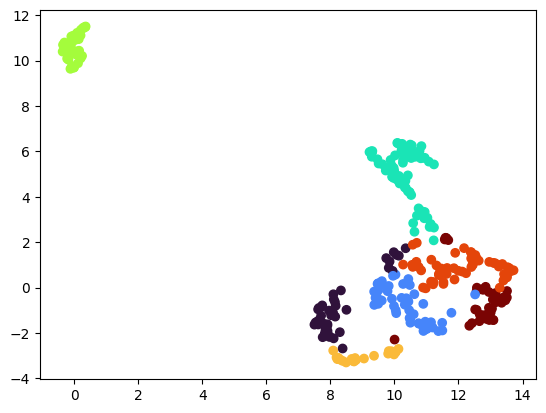

In [13]:
embedding = reducer.fit_transform(new_waveforms)

umap_df = pd.DataFrame(embedding, columns=('x', 'y'))

umap_df['waveform'] = list(new_waveforms)

umap_df['cluster_id'] = clustering_solution

cmap = plt.get_cmap("turbo")

colors = cmap(np.linspace(0, 1, len(set(clustering_solution))))

umap_df['cluster_color'] = [colors[i] for i in clustering_solution]

plt.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(),

marker='o', c=umap_df['cluster_id'].tolist(), cmap='turbo')

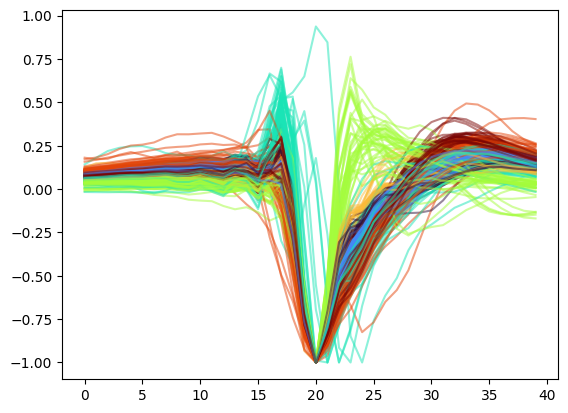

In [14]:
f,arr = plt.subplots(1)

for i,row in enumerate(umap_df['waveform'].tolist()):
    arr.plot(umap_df['waveform'].tolist()[i],c=umap_df['cluster_color'].tolist()[i],alpha=0.5)

In [15]:
umap_df.to_csv('all_neg_umap_df.csv')

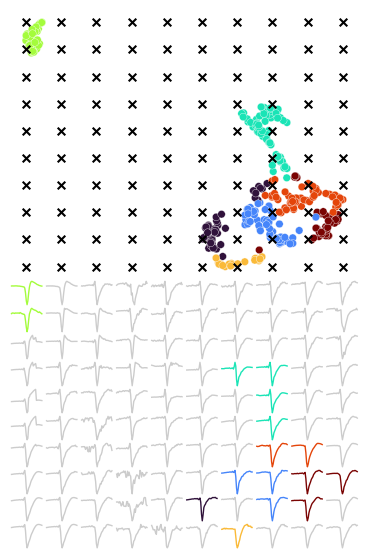

In [17]:
plot_inverse_mapping(reducer, umap_df)

In [19]:
umap_model, conf_mat = train_gridsearch_classifier(umap_df)

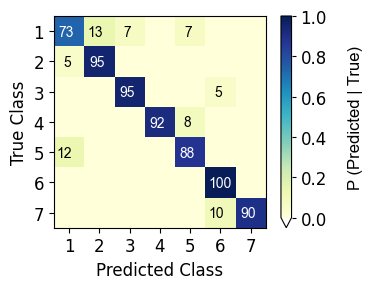

In [21]:
plot_confusion_matrix(conf_mat,umap_df)

In [23]:
xgbModel = xgb.XGBClassifier(umap_model.best_params_)

xgbModel.fit(umap_df['waveform'].tolist(),umap_df['cluster_id'].tolist())

explainer = shap.TreeExplainer(xgbModel)

Pass `objective` as keyword args.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


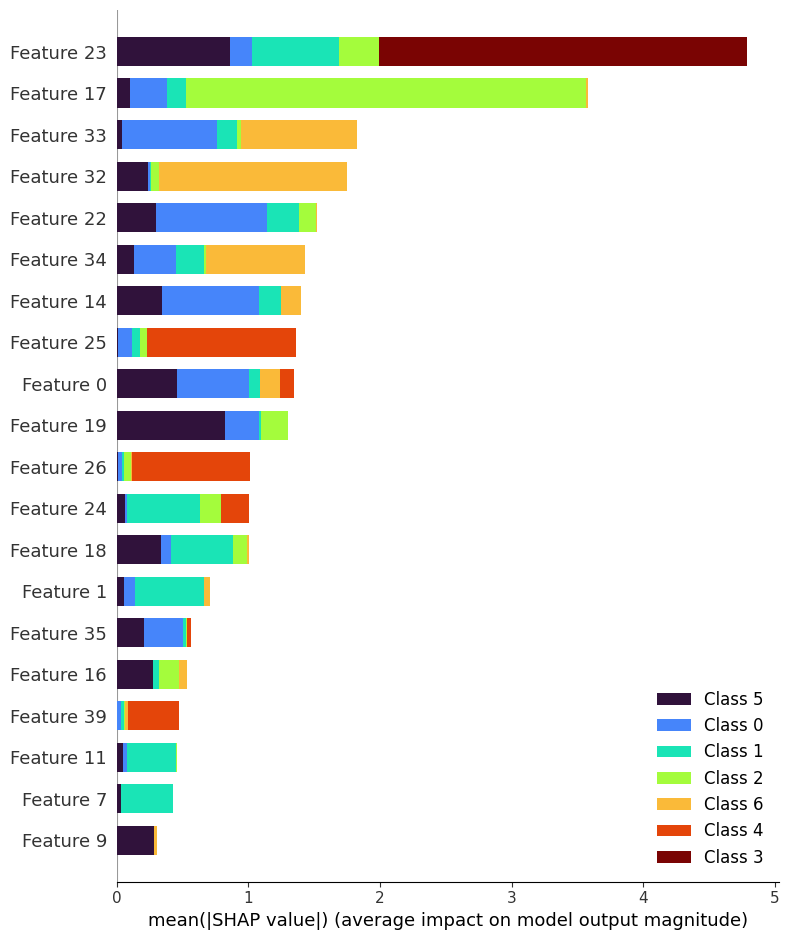

In [25]:
umap_cmap = mpl.colors.ListedColormap(colors, name='umap_cmap')

shap_values = explainer.shap_values(umap_df['waveform'].tolist())

shap.summary_plot(shap_values, color = umap_cmap)

In [26]:
cluster_ids

array([ 45,  60,  67, 109, 124, 146, 148,   8,  14,  32,  39,  44,   9,
        13,  18,  20, 115, 117, 123, 150, 154, 190,   3,  15,  18,  47,
        60,  72,  76,  89, 101, 103,   1,   3,   4,   7,  27,  32,   0,
         4,  18,  24,  27,  42,  49,  54,  68,  75,  81,   8,  13,  19,
        31,  32,  33,  42,  59,  63,  66,  75,  82,  93,  94,  95,  98,
       110, 111, 116, 120, 124, 150,  13,  23,  24,  25,  27,  28,  36,
        52,  58,  59,  73,  77,  83, 101, 158, 169, 177, 183, 194, 210,
       216,  14,  86,  92, 156, 160, 164, 170, 171,  28,  92, 111, 154,
       176, 125, 130, 149, 181, 192, 210, 252, 279, 282, 285,   6,  18,
        23,  25,  27,  29,  33,  36,  43,  68,  69,  75,  76,  77,  79,
        80,  11,  20,  27,  29,  33,  42,  46,  64,  77,  79,  96, 100,
       101, 125, 145, 147,  21,  26,  35,  40,  54,  59,  91, 108, 109,
       158, 160, 166, 173, 196, 210, 217, 234, 248, 274, 286, 302, 304,
        17,  36,  38,  44,  45,  50,  52,  84,  88,  93,   0,  3

In [27]:
len(cluster_ids)

335